## 13.2 动态规划求解0/1背包问题
`0/1`背包问题是我们在第12章里介绍过的优化问题之一。回顾一下，我们介绍了一个复杂度为`O(nlog n)`的贪心算法，但不保证能找到一个最优解。我们还介绍了一个能保证找到最优解的暴力算法，但复杂度为指数级。最后，我们讨论了“**该问题本质上是关于输入大小为指数级的**”这一事实。最坏情形下，一个人不查看所有可能的答案是不可能找出最优解的。

幸运的是，情形并没有那么糟。动态规划提供了一种在合理时间内解决大部分0/1背包问题的实践解。作为推导这样一个解的第一步，我们从基于穷尽枚举法的一个指数级的解开始。关键思想是：**通过构建一个可枚举所有满足重量约束的有根的二叉树来探索可能的解空间**。

定义 有根的二叉树

一个有根的二叉树一个无环的有向图，它满足：
- 仅存在一个无父节点的节点，即根节点；
- 每个非根节点仅有2个子节点；
- 每个节点最多有两个子节点，没有子节点的节点称为叶子节点。

0/1背包问题的搜索树中的每个节点可用一个四元组来表示，它表示背包问题的一个局部解：
- 一个由已拾取物品组成的集合；
- 一个还没有做过判断的物品列表；
- 已拾取的物品集的总价值；
- 背包的剩余空间；

这个树是从根开始从上往下开始构建的。每次从待考虑的物品中选择一个。如果背包中还留有该物品的空间，则构建一个反映选择拾取该物品的节点。根据约定，我们将该节点作为左子节点。右子节点反映没拾取该物品。然后持续应用这个过程直到背包满了，或者物品考虑完了。因为每条边反映一个决定，因此这样的树也称为**决策树**。


图13.3是一个描述物品的列表。
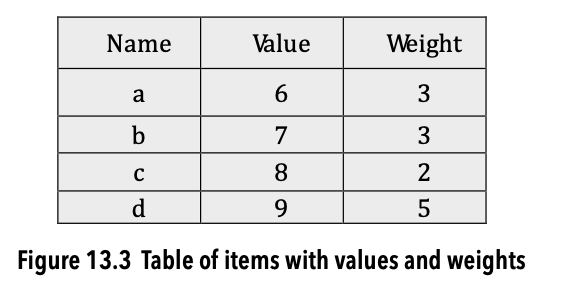

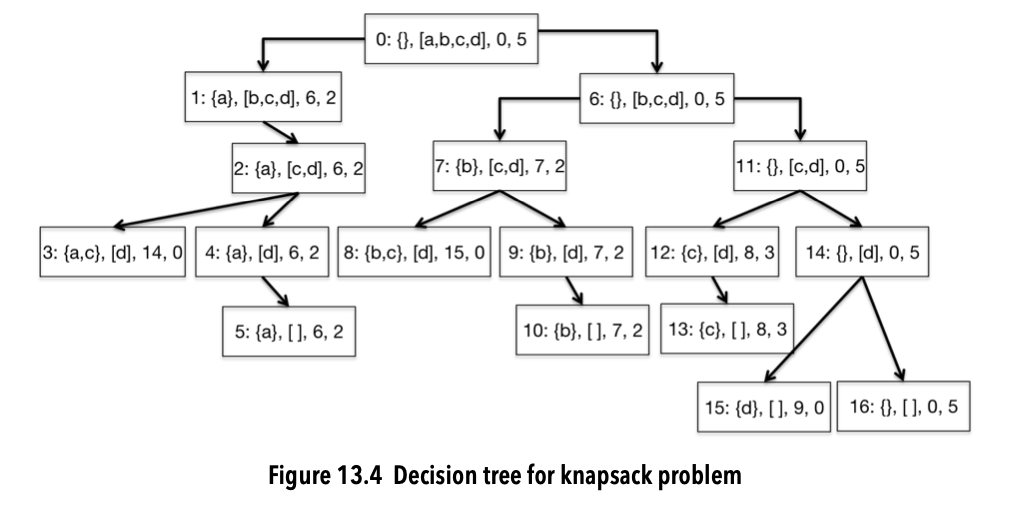
图13.4是一棵决定拾取哪些物品的决策树，假设背包的最大重量为5。树根(节点0)的标签为`({},[a,b,c,d],0,5)`，表示没有拾取物品、剩余待考虑的物品列表、已拾取的物品总价值为0、背包剩余空间为5。节点1的标签为`({a},[b,c,d],6,2)`，表明已拾取1个物品、剩余待考虑的物品列表为`[b,c,d]`、已拾取物品的总价值为6、背包剩余空间为2。注意：节点1没有左孩子，因为物品b的重量为3，背包的剩余空间不够放入它。

在图13.4中，在每个节点里的冒号前的数字表明节点生成的顺序。这个特殊的顺序叫做左先-深度优先。

在每个节点处，我们尝试生成一个左节点。如果这是不可能的，则我们尝试生成一个右节点。如果这也是不可能的，则我们就向上回退一个节点，重复这个过程。直到我们发现已生成根节点的所有后代，过程终止。当节点终止时，已生成了可塞进背包的每个物品组合。任何一个具有最大价值的叶子节点就表示一个最优解。

注意：对每个叶子节点，要么第二个元素是空列表，要么第4个元素为0。

不幸的是，一个深度优先树的自然实现是递归的。

In [8]:
class Item(object):
    def __init__(self, n, v, w):
        self.name = n
        self.value = v
        self.weight = w
        
    def getName(self):
        return self.name
    
    def getValue(self):
        return self.value
    
    def getWeight(self):
        return self.weight
    
    def __str__(self):
        result = '<'+self.name+', '+str(self.value)\
        +', '+str(self.weight)+'>'
        
        return result

In [20]:
def maxVal(toConsider, avail):
    """
    假设toConsider是一个物品列表，avail是一个重量，
    返回一个元组，其中第一个元素是0/1背包问题的一个解的总价值，第二个元素是构成解的物品列表
    """
    if toConsider == [] or avail == 0:
        result = (0,())
    elif toConsider[0].getWeight()>avail:
        #只探索右分支
        result = maxVal(toConsider[1:], avail)
    else:
        nextItem = toConsider[0]
        #探索左分支
        withVal, withToTake = maxVal(toConsider[1:], avail - nextItem.getWeight())
        withVal += nextItem.getValue()
        #探索右分支
        withoutVal, withoutToTake = maxVal(toConsider[1:], avail)
        #选择一个更好的分支
        if withVal > withoutVal:
            result = (withVal, withToTake+(nextItem,))
        else:
            result = (withoutVal, withoutToTake)
            
    return result

In [21]:
def smallTest():
    names = ['a','b','c','d']
    vals = [6,7,8,9]
    weights = [3,3,2,5]
    Items = []
    for i in range(len(vals)):
        Items.append(Item(names[i], vals[i], weights[i]))
    
    val, taken = maxVal(Items, 5)
    for item in taken:
        print(item)
    print('Total value of items taken =', val)

In [22]:
smallTest()

<c, 8, 2>
<b, 7, 3>
Total value of items taken = 15


分析：

- 这个实现使用了来自图12.2中的类`Item`。

- 函数`maxVal`返回了两个值：已拾取的物品集合，以及那些物品的总价值。

  用两个参数调用`maxVal`函数，对应的是树中节点标签的第2个元素和第4个元素：
  - toConsider：树中靠上的还未考虑的节点中对应的物品；
  - avail：还可用的空间大小；


注意：`maxVal`不是先构建决策树，后找最优节点。而是使用局部变量`result`来记录截止目前找到的最好的解。